In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import row
output_notebook()
import seaborn as sns

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

Loading BokehJS ...

In [2]:
def myAcp(df):
    
    sc = StandardScaler() 
    Z = sc.fit_transform(features)
    acp = PCA(svd_solver='full')
    coord = acp.fit_transform(Z) 
    
    return pd.DataFrame(coord)

In [3]:
def traitement_types(df):
    df_ = df.copy().replace('\\N',np.NAN)
    
    for c in df_.columns:
        if 'crd_' in c or c in ['CRD','IMPAYES_DEBUT','age','adulte_foyer']:
            df_[c] = pd.to_numeric(df_[c], errors='coerce')
        
    df_.moy_eco_jour = df_.moy_eco_jour.str.replace(',', '.', regex=False).astype(float)
    df_.RAV_UC = df_.RAV_UC.str.replace(',', '.', regex=False).astype(float)
    
    df_['Date'] = pd.to_datetime(df_.year.astype(str) + '-' + df_.month.astype(str), format='%Y-%m')
    df_ = df_.drop(columns=['year','month'])
    
    return df_


In [223]:
def trancheAge(x):
    age = round(x.age)
    if age < 25:
        return '<25ans'

    elif age >= 25 and age <= 34:
        return  '25-34ans'

    elif age >= 35 and age <= 44:
        return  '35-44ans'

    elif age >= 45 and age <= 54:
        return  '45-54ans'

    elif age >= 55 and age <= 64:
        return  '55-64ans'

    elif age >= 65 and age <= 74:
        return  '65-74ans'

    elif age >= 75:
        return '>75ans'
    
    
def traitement_na(df):
    df_ = df.copy()
    
    df_ = df_.replace('Non Renseigne', np.NAN)
    for CRD in df_.columns.tolist():
        if 'crd_' in CRD:
            df_[CRD] = df_[CRD].fillna(0)
            
    
    # Catégoriser la PROFESSION selon la proximité des revenus
    revenus_prof = {}
    for p in df_.PROF.unique():
        REV = df_.loc[df_.PROF == p, 'REVENUS'].mean()
        try:
            revenus_prof[p] = round(REV)
        except:
            pass
    
    correct_PROF = df_.REVENUS.apply(lambda x: min(revenus_prof.items(), key=lambda v: abs(v[1] - int(x)))[1])
    df_['PROF'] = df_['PROF'].fillna(correct_PROF)
        
        
    
    # Catégoriser la cat_RAV_UC selon la proximité des Reste A Vivre Ouverture
    cat_RAV_ = {}
    for r in df_.cat_RAV_UC.unique():
        REV = df_.loc[df_.cat_RAV_UC == r, 'RAV_ouverture'].mean()
        try:
            cat_RAV_[r] = round(REV)
        except:
            pass
    
    correct_RAV = df_.RAV_ouverture.apply(lambda x: min(cat_RAV_.items(), key=lambda v: abs(v[1] - int(x)))[1])
    df_['cat_RAV_UC'] = df_['cat_RAV_UC'].fillna(cat_RAV_)
    
    
    
        
    for p in df_.PROF.unique():
        med = df_.loc[df_.PROF == p].age.median()
        df_.loc[df_.PROF == p, 'age'] = df_.loc[df_.PROF == p, 'age'].fillna(med)
    
    # Tranche d'age en fonction de l'age précedement calculé
    df_.tranche_age = df_.apply(lambda x: trancheAge(x), axis=1)
    
    
    # Il y a 60% de '2' dans adulte foyer
    df_.adulte_foyer = df_.adulte_foyer.fillna(2)
    # Peu important 
    df_.situation = df_.situation.fillna('autre')
    # Trop de cas pssibles, malgrès une majorité (50%) d' Endettement 
    df_.NATURE_DIFF = df_.NATURE_DIFF.fillna('autre')
    # Peu important 
    df_.region = df_.region.fillna('inconnu')
    # Peu important 
    df_.cat_moy_eco_jour = df_.cat_moy_eco_jour.fillna('inconnu')
    # Majorité
    df_.LOGEMENT = df_.LOGEMENT.fillna('locataire')
    # NA environ 0 
    df_.moy_eco_jour = df_.moy_eco_jour.fillna(0)
    # Valeur majoritaire
    df_.cat_credit = df_.cat_credit.fillna('1€-499€')
    # Valeur medianne
    df_.CRD = df_.CRD.fillna(df_.CRD.median())
    
    
    # Colonnes peu exploitables
    df_ = df_.drop(columns=['IMPAYES_DEBUT','STRUCTURE PRESCRIPTRICE'])
    
    df_.gain_mediation = df_.gain_mediation.fillna(0).astype(int)
    
    df_.cat_impayes = df_.cat_impayes.fillna('Inconnu')
    
    #df_ = df_.dropna()
    
    return df_

In [148]:
def mega_traitement(df,dummies=False):
    df_ = df.copy()
    df_ = traitement_types(df_)
    df_ = traitement_na(df_)

    ## ?? A RETIRER ?? ##
    for cc in list(df_.dtypes[df_.dtypes == 'object'].to_dict().keys()):
        print(cc)
        cat_dtype = pd.api.types.CategoricalDtype(categories=df_[cc].unique().tolist(), ordered=False)
        df_[cc] = df_[cc].astype(cat_dtype)
    ################
    
    if dummies:
        or_dummies = pd.get_dummies(df_.ORIENTATION)
        df_[df_.ORIENTATION.unique().tolist()]=or_dummies
    
    for cat in list(df_.dtypes[df_.dtypes == 'object'].to_dict().keys()):
        gle = LabelEncoder()
        print(cat)
        df_[cat] = gle.fit_transform(df_[cat])
    
    return df_

Nous pouvons définir les **types d'orientation** comme colonne afin de distinguer (dans la **corrélation**), quelle features **influe** sur chaque type d'Orientation.

In [225]:
traitement_na(traitement_types(test)).isna().sum().sort_values(ascending=False)

RAV_UC               79
cat_RAV_UC           79
Date                  0
LOGEMENT              0
cat_credit            0
CREDITS               0
cat_charges           0
CHARGES               0
cat_rev               0
REVENUS               0
PROF                  0
RAV_ouverture         0
pers_a_charge         0
adulte_foyer          0
situation             0
tranche_age           0
age                   0
NATURE_DIFF           0
region                0
PLATEFORME            0
cat_impayes           0
cat_RAV_ouverture     0
cat_moy_eco_jour      0
nb_credits            0
moy_eco_jour          0
crd_decouvert         0
nb_decouvert          0
crd_autres            0
nb_autres             0
crd_rac               0
nb_rac                0
crd_immo              0
nb_immo               0
crd_renouv            0
nb_renouv             0
crd_amort             0
nb_amort              0
gain_mediation        0
CRD                   0
id                    0
dtype: int64

In [177]:
train = pd.read_csv('data/train.csv')
#train = mega_traitement(train,dummies=True)

test = pd.read_csv('data/test.csv')
#test = mega_traitement(test,dummies=False)

In [7]:
train.head()

,id,STRUCTURE PRESCRIPTRICE,PLATEFORME,year,month,region,ORIENTATION,NATURE_DIFF,age,tranche_age,...,nb_immo,crd_immo,nb_rac,crd_rac,nb_autres,crd_autres,nb_decouvert,crd_decouvert,moy_eco_jour,cat_moy_eco_jour
0,1550,PRESCRIPTEUR35,bancaire,2015,7,BOURGOGNE FRANCHE COMTE,Surendettement,Surendettement,\N,Non Renseigne,...,0,\N,0,\N,0,\N,0,\N,"2,53333","0a2,99€"
1,2249,PRESCRIPTEUR16,bancaire,2016,2,OCCITANIE,Mediation,Endettement,\N,Non Renseigne,...,0,\N,0,\N,0,\N,0,\N,"-3,31667",Négatif
2,2670,PRESCRIPTEUR18,social,2016,4,PROVENCE-ALPES-COTE-D'AZUR,Accompagnement,Endettement,\N,Non Renseigne,...,0,\N,0,\N,1,3996,0,\N,"-24,7667",Négatif
3,1102,PRESCRIPTEUR6,bancaire,2014,11,BRETAGNE,Mediation,Multiendettement,\N,Non Renseigne,...,0,\N,0,\N,0,\N,0,\N,"29,5667",15€et+
4,7069,PRESCRIPTEUR23,social,2018,9,NOUVELLE AQUITAINE,Accompagnement,Difficultés de Gestion,24,<25ans,...,0,\N,0,\N,0,\N,0,\N,"-19,15",Négatif


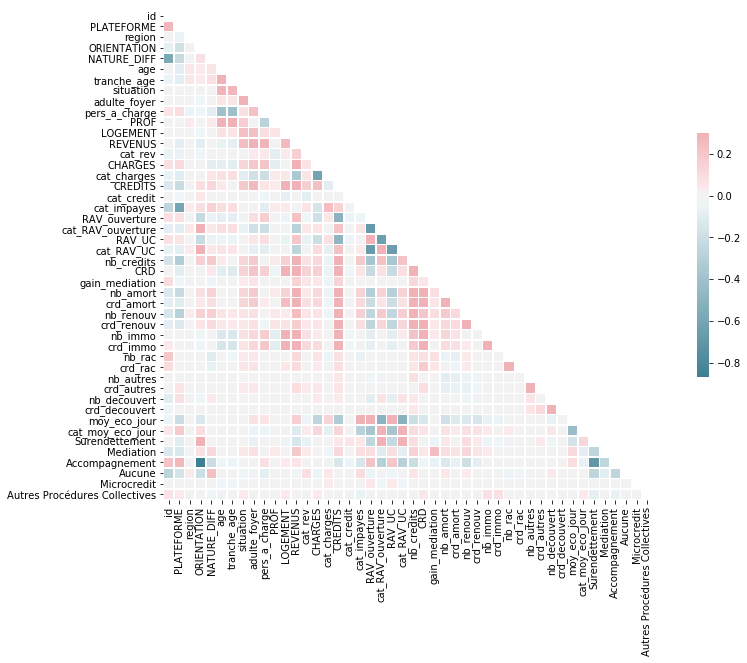

In [8]:
corr = train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(16, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

# I - Random Forest

In [10]:
or_dummies = list(train.columns[-6:])
to_drop = ['Date','id'] + or_dummies

X = train.drop(columns=to_drop +['ORIENTATION'])
y = train[['ORIENTATION']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3, 4, 5],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

clf = RandomForestClassifier()

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

In [12]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


/Users/william/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.4min
/Users/william/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  2.2min
[Parallel(n_jobs=

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 5,
 'min_samples_leaf': 4,
 'min_samples_split': 12,
 'n_estimators': 100}

In [14]:
best_grid = grid_search.best_estimator_
best_grid

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=90, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=12,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [36]:
resultats = pd.DataFrame({'label':best_grid.predict(X_test)})
resultats['ORIENTATION'] = y_test['ORIENTATION'].values

In [42]:
pd.DataFrame(resultats.ORIENTATION == resultats.label).sum()/resultats.shape[0]

0    0.598732
dtype: float64

## Entrainer le modèle une nouvelle fois mais avec les paramètres de la meilleur grille

In [50]:
clf_best = RandomForestClassifier(max_depth=90, bootstrap=True, max_features=5, min_samples_leaf=4, min_samples_split=12, n_estimators=100)
clf_best.fit(X_train, y_train)

/Users/william/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=90, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=12,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Ensemble de test

In [63]:
train.ORIENTATION.unique()

array([5, 3, 0, 1, 4, 2])

In [64]:
orientation_help =pd.read_csv('data/train.csv')
orientation_help.ORIENTATION.unique()

array(['Surendettement', 'Mediation', 'Accompagnement', 'Aucune',
       'Microcredit', 'Autres Procédures Collectives'], dtype=object)

In [100]:
test = pd.read_csv('data/test.csv')
test = mega_traitement(test,dummies=False)
test_ = test.drop(columns=['Date','id'])

PLATEFORME
region


ValueError: Categorial categories cannot be null

In [85]:
test_.head()

,PLATEFORME,region,NATURE_DIFF,age,tranche_age,situation,adulte_foyer,pers_a_charge,PROF,LOGEMENT,...,nb_immo,crd_immo,nb_rac,crd_rac,nb_autres,crd_autres,nb_decouvert,crd_decouvert,moy_eco_jour,cat_moy_eco_jour
0,bancaire,OCCITANIE,Endettement,62.0,55-64ans,veuf,2.0,0,retraité,proprietaire,...,1,25042.0,1,576940.0,0,0.0,0,0.0,-4.550000,Négatif
1,social,BRETAGNE,Impayés,41.0,35-44ans,marie,2.0,3,employé,locataire,...,0,0.0,0,0.0,2,3240.0,0,0.0,5.800000,"3a5,99€"
2,bancaire,GRAND EST,NaN,45.0,45-54ans,marie,2.0,3,chomeur,locataire,...,0,0.0,0,0.0,1,400.0,0,0.0,-0.373333,Négatif
3,bancaire,OCCITANIE,Impayés,47.0,45-54ans,divorce,1.0,0,fonctionnaire,locataire,...,0,0.0,0,0.0,0,0.0,0,0.0,10.300000,"10a14,99€"
4,bancaire,AUVERGNE RHONE ALPES,Endettement,73.0,65-74ans,celibataire,1.0,0,retraité,proprietaire,...,0,0.0,0,0.0,0,0.0,0,0.0,15.066700,15€et+


## Faire un dict pour orienatation.remplacement dans les fonctions de traitement

In [94]:
submission = pd.DataFrame()
submission['id'] = test.id
submission['ORIENTATION'] = clf_best.predict(test_)

dict_orienta = {5:'Surendettement',3:'Mediation',
                    0:'Accompagnement',1:'Aucune',
                   4:'Microcredit',2:'Autres Procédures Collectives'}
submission.ORIENTATION = submission.ORIENTATION.replace(dict_orienta)

ValueError: could not convert string to float: 'bancaire'

In [71]:
submission.head(10)

,id,ORIENTATION
0,5119,Accompagnement
1,2519,Accompagnement
3,2841,Accompagnement
4,7840,Accompagnement
5,1613,Accompagnement
6,4883,Accompagnement
7,75,Surendettement
8,5836,Accompagnement
10,233,Mediation
11,7881,Accompagnement


In [76]:
train.ORIENTATION.value_counts(normalize=True).round(2)

5    0.41
0    0.41
1    0.09
3    0.08
2    0.01
4    0.00
Name: ORIENTATION, dtype: float64

In [75]:
submission.ORIENTATION.value_counts(normalize=True).round(2)

Surendettement    0.53
Accompagnement    0.44
Mediation         0.02
Aucune            0.01
Name: ORIENTATION, dtype: float64

In [77]:
submission.shape

(3107, 2)

In [72]:
submission.to_csv('submission.csv',index=False)